# 불확실성 추정

 - 자율주행, 의료 진단 및 재무 예측과 같은 도메인에서 머신러닝을 수행했을 경우, 예측에 대한 실수는 치명적인 결과를 초래하거나 막대한 재정적 손실을 발생시킬 수 있다. 예측에 대한 오류를 감지하고 안전한 조치를 취하는 것이 중요하며, 발생가능한 예측 오차에 대한 정보를 인지하고 라벨을 설정하는 능동적 학습을 통해 올바르게 예측을 하도록 모델을 훈련하는 것이 필요하다. 
 
 
 - 예측 불확실성 추정은 예측에 대한 오류 또는 실수를 감자하는데 사용될 수 있다. 일반적으로 예측 모델은 예측 오차가 큰 상황에서 높은 불확실성을 나타내는데 불확실성의 원인에 따라 다르게 조치된다. 많은 연구에서 불확실성 발생 원인을 크게 두 가지로 요약한다. 첫 번째는 aleatoric 불확실성(데이터 불확실성)과 두 번째 epistemic uncertainty(모델 불확실성)이다. 
 
 
 - 데이터 불확실성에 의해 발생된 예측 불확실성은 (1) 데이터에 내재된 노이즈에 의해 발생되며 (2) 추가적으로 더 많은 데이터를 학습해도 오차를 줄 일 수 없는 특성을 가졌다. 모델 불확실성에 의해 발생된 예측 불확실성은 모델이 데이터에 대해 얼마나 적합하게 구축이 되었는지 및  데이터의 어떤 특징을 학습하는지에 대해 모르는 정도에 영향을 받고, 학습이 잘 안 된 부분에 대해 더 많은 데이터가 학습된다면 불확실성이 줄여질 수 있는 특성을 가지고 있다. 


 - 다음은 불확실성 추정에 관한 예시이다. 

In [17]:
import numpy as np
import math
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

- 각각 9개의 값을 갖는 두 개의 범주형 특성 x₁ 및 x₂가 있다고 가정하고(가능한 특성 조합이 81개가 존재), Target(y)은 다음과 같이 따른다. 

- y = 평균(x₁,x₂) + eps(x₁,x₂)

- 여기서 평균 (x₁,x₂) 은 알려지지 않은 고정 값이고 eps (x₁,x₂) 는 평균이 0이고 분산이 var (x₁,x₂) 인 정규 분포 잡음(즉, 데이터 불확실성)이다. 즉, 평균 (x₁,x₂) 은 무작위로 생성되고 var (x₁,x₂) 는 다음과 같이 분포되는 두 개의 값(0.01 및 0.04)로 이뤄진다. 

In [18]:
# 평균과 분산을 생성하는 함수 정의
def gen_parameters(noise=0.01, seed=0):
    
    np.random.seed(seed)
    
    mean = np.random.rand(9, 9)
    
    figure = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 4, 4, 4, 4, 4, 1, 1],
        [1, 1, 4, 0, 0, 0, 4, 1, 1],
        [1, 1, 4, 0, 0, 0, 4, 1, 1],
        [1, 1, 4, 0, 0, 0, 4, 1, 1],
        [1, 1, 4, 4, 4, 4, 4, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

    var = figure*noise
    
    return mean, var

데이터 불확실성(분산)에 대한 그래프: white 영역은 학습 데이터가 없음을 의미하는 이상치


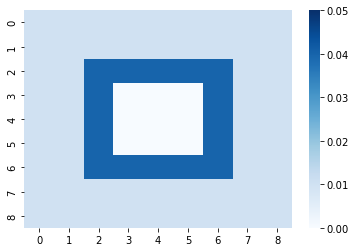

In [21]:
# 시각화
mean, var = gen_parameters()
print("데이터 불확실성(분산)에 대한 그래프: white 영역은 학습 데이터가 없음을 의미하는 이상치")

sns.heatmap(var, cmap="Blues", vmax=0.05)
plt.show()

In [5]:
# 학습 및 검증 데이터 생성하는 함수 정의
def generate_training_data(n_samples, mean, var, num_cat=9, seed=0):
    np.random.seed(seed)
    train = []
    target = []
    val = []
    val_target = []
    for i in range(num_cat):
        for j in range(num_cat):
            if var[i, j] == 0:
                continue
            for _ in range(n_samples):
                train.append([i, j])
                val.append([i, j])
                target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                val_target.append(np.random.normal(mean[i, j], math.sqrt(var[i, j])))
                
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

In [6]:
# 학습 및 검증 데이터 생성
train, target, val, val_target = generate_training_data(1000, mean, var)

train_pool = Pool(train, target, cat_features = [0, 1])
val_pool = Pool(val, val_target, cat_features = [0, 1])

# 모든 가능한 특성 조합으로 구성된 테스트 데이터 생성
num_cat = 9
test = np.asarray([[i, j] for i in range(num_cat) for j in range(num_cat)])

- RMSE 손실로 최적화된 표준 모델은 평균(x1, x2)만 예측할 수 있다. 
- 그러나 target(y)의 분산, 즉 데이터 불확실성은 추정하기 어렵다.
- 데이터 불확실성을 추정하기 위해서는 평균과 분산 모두 예측이 필요하다. 
- CatBoost 모델에는 RMSEWithUncertainty라는 손실 함수가 있다. 
- 해당 손실 함수는 NGBoost 알고리즘과 유사하게 음의 로그 가능성으로 최적화하고 natural gradients을 사용하여 정규 분포의 평균과 분산을 추정한다.
- 실제로 해당 손실함수를 적용하면 다음과 같은 분산을 얻는다. 

In [7]:
# 평균 값과 데이터 불확실성을 추정

model = CatBoostRegressor(iterations=1000, learning_rate=0.2, loss_function='RMSEWithUncertainty',
                          verbose=False, random_seed=0)

model.fit(train_pool, eval_set=val_pool)
print("best iteration =", model.get_best_iteration())
preds = model.predict(test)

mean_preds = preds[:, 0] # 첫 번째 예측은 추정된 평균값을 의미함. 
var_preds = preds[:, 1] # 두 번째 예측은 추정된 분산을 의미함. 

best iteration = 993


In [22]:
# mask 정의: 실제 사각형 내부의 요소에 대한 마스크 (시각화를 위함)
mask = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

실제 평균 값(with mask):


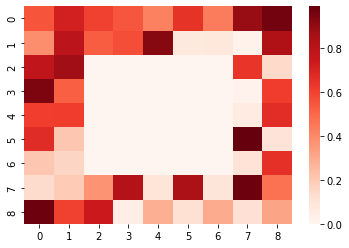

예측된 평균 값(with mask):


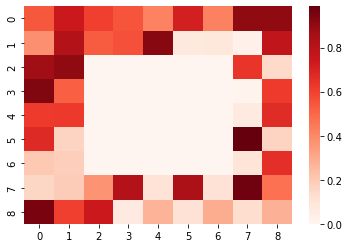

In [24]:
print("실제 평균 값(with mask):")
sns.heatmap(mean*mask, cmap="Reds")
plt.show()

print("예측된 평균 값(with mask):")
sns.heatmap(mean_preds.reshape([num_cat, num_cat])*mask, cmap="Reds")
plt.show()

추정된 데이터 불확실성:


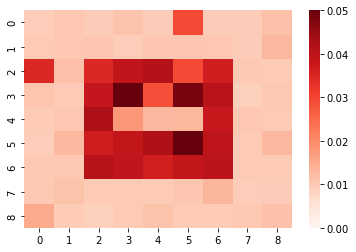

In [25]:
print("추정된 데이터 불확실성:")
sns.heatmap(var_preds.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
plt.show()

- 그래프을 통해 CatBoost가 사각형 경계선과 사각형 외부의 분산을 성공적으로 예측하는 것을 볼 수 있다. 
- 다만 심장 내부에는 훈련 데이터가 없으므로 해당 영역의 예측 결과는 다소 실제와 다르다. 
- 즉, 모델 불확실성에 대한 추정이 필요하다. 
- 이렇게 데이터의 노이즈를 추정하여 데이터 불확실성을 추정할 수 있다. 
- 그러나 특정 영역의 학습 데이터 부족으로 발생되는 모델 불확실성을 추정하기 위해 추가적으로 모델의 앙상블이 필요하다. 
- 해당 아이디어의 출발은 모든 모델이 만약 입력 데이터를 잘 이해했다면 모두 유사한(낮은 모델 불확실성) 예측 결과를 만들어내는 반면, 
- 만약 입력 데이터를 이해하지 못한다면 다양한(높은 모델 불확실성) 예측 결과를 제공하게 된다. 
- 회귀에서는 모델 불확실성은 여러 모델의 분산의 평균을 통해 얻을 수 있다. 
(주의할 것은 이것이 단일 모델의 예측된 분산과 다르다).  

- 얻은(무작위) 예측이 잘 분산될 수 있게 posterior_sampling 옵션을 사용하여 모델을 생성한다. 
(A. Ustimenko, L. Prokhorenkova and A. Malinin, Uncertainty in Gradient Boosting via Ensembles” (2020), arXiv preprint arXiv:2006.10562참고)
- 여러 모델에 대한 앙상블 모델을 구축한 뒤 다음과 같이 모델 불확실성을 추정한다. 
- 모델 불확실성 = np.var(ens_preds, axis=0)[:, 0]

In [11]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False)
        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(test))
    return ens_preds

Knowledge uncertainty via ensemble:


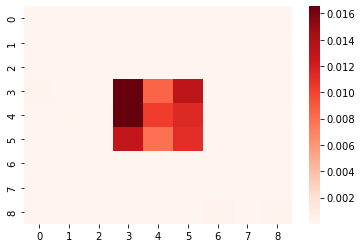

Average predicted data uncertainty:


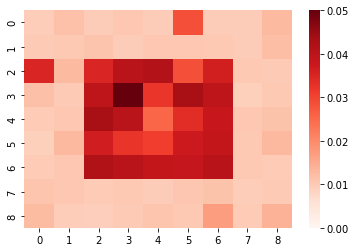

In [12]:
ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2)
ens_preds = np.asarray(ens_preds)
data = np.mean(ens_preds, axis=0)[:, 1] # average estimated data uncertainty
knowledge = np.var(ens_preds, axis=0)[:, 0] # estimated knowledge uncertainty

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
plt.show()

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
plt.show()

- 그래프를 통해 앙상블 모델이 사각형 내부의 모델 불확실성을 올바르게 감지한 것을 확인할 수 있다. 
- 즉, 앙상블 모델을 통해 추정하는 방식을 통해 모델의 불확실성을 추정할 수 있다. 
- 그러나 실제로 여러 모델의 앙상블을 훈련하는 데 비용이 너무 커지는 이슈가 있다. 
- 가장 이상적인 방식은 단일 모델을 훈련하여 예측 불확실성을 감지하는 것이다. 
- 단일 훈련 모델에서 얻은 가상 앙상블 방식을 사용할 수 있다.

In [13]:
def virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2, seed=0):
    ens_preds = []
    model = CatBoostRegressor(iterations=iters, learning_rate=lr, loss_function='RMSEWithUncertainty', 
                              posterior_sampling=True, verbose=False, random_seed=seed)
    model.fit(train_pool, eval_set=val_pool)
    ens_preds = model.virtual_ensembles_predict(test, prediction_type='VirtEnsembles', virtual_ensembles_count=num_samples)
    return ens_preds

In [ ]:
# 추정된 결과는 다음과 같다. 

앙상블 모델을 통해 추정한 모델 불확실성 시각화 그래프:


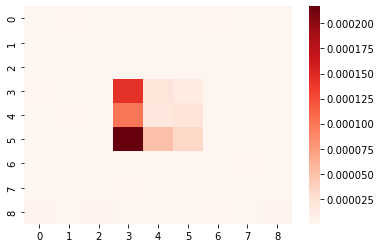

추정한 데이터 불확실성을 시각화한 그래프:


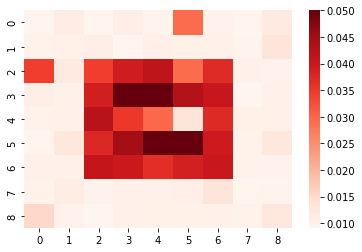

In [26]:
ens_preds = virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2)

ens_preds = np.asarray(ens_preds)
ens_preds = ens_preds

data = np.mean(ens_preds, axis = 1)[:,1]
knowledge = np.var(ens_preds, axis = 1)[:,0]

print("앙상블 모델을 통해 추정한 모델 불확실성 시각화 그래프:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()

print("추정한 데이터 불확실성을 시각화한 그래프:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Reds", vmax = 0.05)
plt.show()

- 그래프를 통해 모델 불확실성에 대한 예측 절대값은 훨씬 작아진 것을 확인할 수 있다. 
- 그러나 여전히 비어 있는 영역(이상치)에 대해 성공적으로 감지한 것을 확인할 수 있다. 
- Prediction_type에 대해 여러 모델의 예측을 반환하는 'VirtEnsembles' 대신 'TotalUncertainty'을 사용하여 동일한 결과를 얻을 수 있다. 
- 해당 Prediction_type경우 CatBoost는 가상 앙상블을 사용하여 모든 유형의 불확실성을 계산합니다. 
- 즉, [평균 예측, 모델 불확실성, 데이터 불확실성] 통계를 반환한다. 

In [15]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.2, loss_function='RMSEWithUncertainty', 
                          posterior_sampling=True, verbose=False, random_seed=0)
model.fit(train_pool, eval_set=val_pool)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)

Knowledge uncertainty via virtual ensemble:


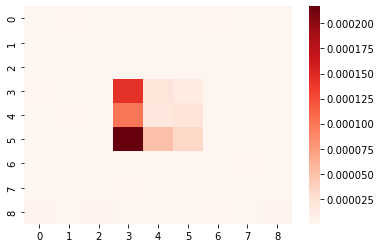

Average predicted data uncertainty:


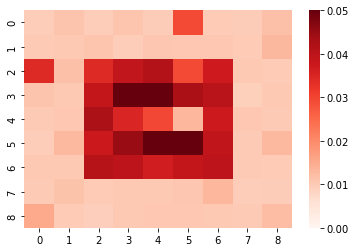

In [16]:
mean_preds = preds[:,0] # mean values predicted by a virtual ensemble

knowledge = preds[:,1] # knowledge uncertainty
print("Knowledge uncertainty via virtual ensemble:")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()

data = preds[:,2] # estimated data uncertainty
print("Average predicted data uncertainty:")
sns.heatmap(data.reshape([num_cat,num_cat]), cmap="Reds", vmin = 0, vmax = 0.05)
plt.show()